# C9orf72 Analysis

This notebook analyzes the cluster membership for c9orf72 patients from AALS

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *
import mogp

from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(font_scale=2)
sns.set_style("white")

col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']

parameters = {'pdf.fonttype': 42}
plt.rcParams.update(parameters)

In [4]:
df_c9 = pd.read_csv('data/raw_data/aals/v_NB_IATI_ALS_Gene_Mutations.csv', index_col='SubjectUID')
df_c9.index = df_c9.index + '_aals'
df_c9['c9orf72'] = df_c9['c9orf72'].map({'1':1, '2':0, '.':0}) #only count positive c9orf72 results

In [5]:
# select best MAP model
exp_path = Path('data/model_data/1_alsfrsr_all')
cur_proj = 'aals'
cur_model_path = exp_path / 'results' / 'rbf'
cur_data_path = exp_path / 'data_{}_min3_alsfrst.pkl'.format(cur_proj)

cur_model_suffix = 'model_{}_min3_alsfrst'.format(cur_proj)
cur_model = get_map_model(cur_model_path, cur_model_suffix, num_seeds=5)
cur_data = joblib.load(cur_data_path)

seed did not pass monotonicity test: 1
seed did not pass monotonicity test: 2
best seed: 3, ll -1278.4487999097823


In [6]:
df_clust_memb = pd.DataFrame(zip(cur_data['SI'],  cur_model.z), columns=['subj_id', 'cluster_id']).set_index('subj_id')
df_clust_memb = df_clust_memb.join(df_c9)

In [7]:
c9_freq = pd.DataFrame()
c9_freq['c9pos']=df_clust_memb.groupby('cluster_id')['c9orf72'].sum()
clust_size = df_clust_memb['cluster_id'].value_counts()
clust_size.name = 'clust_size'
c9_freq = c9_freq.join(clust_size)
c9_freq['freq'] = c9_freq['c9pos'] / c9_freq['clust_size']

In [8]:
c9_freq.sort_values(by='freq', ascending=False,  inplace=True)

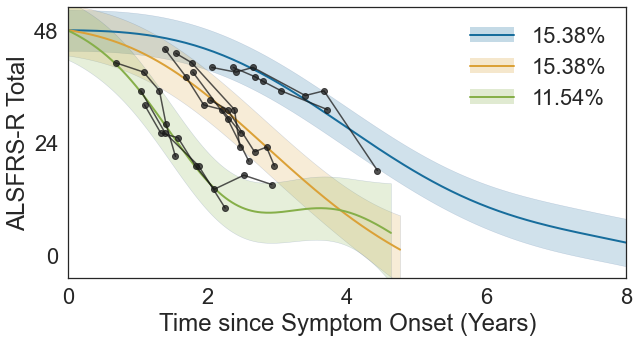

In [9]:
# Visualize clusters with highest proportions of c9orf72 patients
clust_size_thresh = 10
fig, ax = plt.subplots(figsize=(10,5))

vis_clust = c9_freq[c9_freq['clust_size']>clust_size_thresh].index[0:3]

disp_freq = []
for j, cur_k in enumerate(vis_clust):
    cur_disp_freq = '{:.2f}%'.format(c9_freq.loc[cur_k]['freq']*100)
    disp_freq.append(cur_disp_freq)
    _, num_pat = plot_mogp_by_clust(ax, cur_model, cur_data, cur_k, data_flag=False, data_col='k', model_flag=True, model_col=col_palette[j], model_alpha=0.2, gpy_pad=0.5)
    ax.get_legend().remove()

    ind_lis = np.where(np.in1d(cur_data['SI'], df_clust_memb[(df_clust_memb['cluster_id']==cur_k)&(df_clust_memb['c9orf72']==1)].index))
    _ = ax.plot(cur_data['XA'][ind_lis].T[1:], cur_data['YA'][ind_lis].T[1:], 'o-', color='k', alpha=0.75)

_ = format_mogp_axs(ax)

# Edit legend
handles, labels = ax.get_legend_handles_labels()
handles = [(x, matplotlib.patches.Patch(color=x.get_color(), alpha=0.25, linewidth=0)) for x in handles]
labels = disp_freq
_ = ax.legend(handles=handles, labels=labels, frameon=False)
_ = ax.set_ylabel('ALSFRS-R Total')
_ = ax.set_xlabel('Time since Symptom Onset (Years)')

In [10]:
c9_freq[c9_freq['clust_size']>clust_size_thresh]

,c9pos,clust_size,freq
cluster_id,,,
181,2.0,13,0.153846
174,4.0,26,0.153846
91,3.0,26,0.115385
10,2.0,18,0.111111
2,3.0,28,0.107143
3,3.0,28,0.107143
4,3.0,32,0.093750
1,2.0,23,0.086957
6,2.0,29,0.068966
